## 股债平衡交易策略—面向对象实现 & 仓位控制

In [1]:
import tushare as  ts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib.inline

# 定义 account 类，作用是根据每日两种资产的回报率计算账户净值，并记录净值和调仓记录
class Account():
    """
    Account 类定义，模拟账户的各种行为
    """
    def __init__(self, stock=0.5, bond=0.5, rebalance_ratio=0.55):
        """
        类初始化函数，记录初始账户股票和债券的比例以及账户净值
        初始账户净值为1
        :param stock: 股票比例
        :param bond: 债券比例
        """
        self.stock_ratio = stock       # 股票资产比例
        self.bond_ratio = bond         # 债券资产比例
        self.balance_ratio = {'stock': stock, 'bond':bond}  # 调仓后的目标比例，此处与初始值相同
        self.rebalance_threshold = rebalance_ratio          # 调仓阈值
        self.net_value = 1             # 初始账户净值
        self.rebalance_record = {}     # 记录策略调仓记录，检查用途；
        self.balance = {}              # 记录账户策略表现净值


    def rebalance(self):
        """
        账户再平衡，将股票和债券比例调整回目标比例
        ：return:
        """
        self.stock_ratio = self.balance_ratio['stock']
        self.bond_ratio = self.balance_ratio['bond']


    def update_ratio(self, daily_series):
        """
        根据每日收益率数据更新股票和债券持仓比例和策略净值；
        :param daily_series: 每日两种资产的收益率，pandas series
        :return:
        """
        # 股票资产的净值
        stock_net = self.stock_ratio * self.net_value * (1 + daily_series['stock'])
        # 债券资产的净值
        bond_net = self.bond_ratio * self.net_value * (1 + daily_series['bond'])
        # 更新账户总体净值,股票比例，债券比例
        self.net_value = stock_net + bond_net
        self.stock_ratio = stock_net / self.net_value          #更新股票仓位比例；
        self.bond_ratio = bond_net / self.net_value            #更新债券仓位比例；
        # 记录收益进来之后的更新后的账户净值
        self.balance[daily_series.name] = self.net_value


    def check_rebalance(self):
        """
        检查账户是否需要再平衡
        :return: 任何一种资产超过 rebalance_ratio 返回 True
        """
        return (self.stock_ratio >= self.rebalance_threshold) \
               or (self.bond_ratio >= self.rebalance_threshold)


    def data_in(self, daily_series):
        """
        是我们策略的主逻辑；
        处理每天进来的新数据；
        根据当日涨跌幅数据计算账户变动
        此方法设计作为参数传递给pandas.apply()函数
        :param daily_series: series，单日股票和债券资产收益率，index为['stock','bond']
        :return: 返回与 daily_series 结构相同的 series，分别是stock 和 bond 比例更新以后的结果
        """
        # 更新股债资产持仓比例和账户净值，记录账户净值
        self.update_ratio(daily_series)
        # 检查是否 rebalance
        if self.check_rebalance():
            # 记录调仓日期和调仓前的股票债券比例
            self.rebalance_record[daily_series.name] = \
                {'stock': self.stock_ratio, 'bond': self.bond_ratio}
            # 调仓到目标比例
            self.rebalance()
        else:
            pass

        return pd.Series({'stock': self.stock_ratio, 'bond': self.bond_ratio},
                         name=daily_series.name)

In [2]:
# 读取资产收益率，分别用 159922 嘉实中证500ETF 和 511010 国泰上证5年期ETF
change = pd.read_csv('data/fund_change.csv', index_col=0).dropna()
change.columns = ['stock', 'bond']
change.head()

,stock,bond
2013-03-26,-0.003966,0.002424
2013-03-27,0.001138,-0.000241
2013-03-28,-0.028125,0.001064
2013-03-29,0.000585,0.001023
2013-04-01,0.008472,0.001121


In [3]:
change.tail()

,stock,bond
2017-07-26,-0.002390,0.000036
2017-07-27,0.007827,0.000255
2017-07-28,0.005706,0.000036
2017-07-31,0.011820,0.000036
2017-08-01,-0.001558,0.000766


In [4]:
# 获取测试起止时间
test_range = [change.index[0], change.index[-1]]
test_range

['2013-03-26', '2017-08-01']

In [5]:
# 创建 Account 对象，使用默认的股债 50% vs 50% 比例，调仓门槛 55%
account = Account()

In [6]:
# 对收益率数据调用 account.data_in() 方法，每日资产比例变化结果存入 portfolio_ratio 变量
portfolio_ratio = change.apply(account.data_in, axis=1)
portfolio_ratio.head()

,bond,stock
2013-03-26,0.503198,0.496802
2013-03-27,0.502853,0.497147
2013-03-28,0.510250,0.489750
2013-03-29,0.510359,0.489641
2013-04-01,0.508531,0.491469


In [9]:
# 从 account 中读取调仓记录，可以看到至少有一个是超过55%的比例的；
rebalance_record = pd.DataFrame(account.rebalance_record).T
rebalance_record

,bond,stock
2014-08-11,0.449936,0.550064
2014-12-15,0.449297,0.550703
2015-03-23,0.449570,0.550430
2015-05-13,0.448173,0.551827
2015-06-02,0.444598,0.555402
2015-06-26,0.552955,0.447045
2015-07-03,0.551217,0.448783
2015-07-08,0.551194,0.448806
2015-07-13,0.427568,0.572432
2015-08-25,0.566632,0.433368


In [11]:
portfolio_ratio.loc['2014-12-15']

bond     0.5
stock    0.5
Name: 2014-12-15, dtype: float64

In [12]:
# 从 account 中读取账户净值
net_value = pd.Series(account.balance, name='strategy')
net_value.head()

2013-03-26    0.998469
2013-03-27    0.998912
2013-03-28    0.985480
2013-03-29    0.986276
2013-04-01    0.990932
Name: strategy, dtype: float64

In [13]:
## 计算benchmark收益率
# 从 tushare 获取沪深300收盘数据
hs300 = ts.get_k_data('hs300',start ='2013-01-01', end = '2017-08-01').set_index('date')['close']
# 计算日涨跌幅
hs300 = (hs300 - hs300.shift(1))/hs300.shift(1)
# 修改 series.name ，pd.concat时可以直接转为列名称
hs300.name = 'hs300'
# 截取测试对应时间段数据
hs300 = hs300[(hs300.index >= test_range[0]) & (hs300.index <= test_range[1])]
# 计算累计收益
hs300 = (hs300 + 1).cumprod()
hs300.head()

date
2013-03-26    0.985439
2013-03-27    0.988684
2013-03-28    0.956450
2013-03-29    0.954835
2013-04-01    0.954112
Name: hs300, dtype: float64

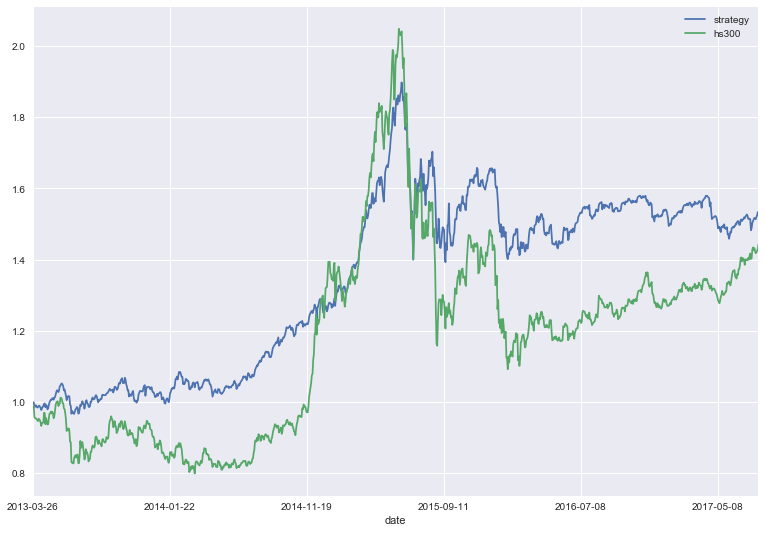

In [14]:
# 形成净值曲线
returns= pd.concat([net_value, hs300], axis=1)
returns.plot(figsize=(13,9))
plt.show()

声明：本资料仅供内部学习交流使用，切勿外传。